In [1]:
import math
import operator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy import spatial


In [2]:

"""
readDataInMem: Read data from provided file into a list (one record per line)
               Returns list
"""

def readDataInMem():
    cols=[]
    rows=[]
    with open("../data/MasterAdjList",'r') as fr:
        for line in fr:
            cols=line.split()
            if cols[-1]=='\\N':
                cols[-1]='0'
            cols=list(map(int,cols))
            rows.append(cols)
    return rows

In [3]:
userInfoDict={}
with open("../data/MasterUserFeatureMatrix.txt", 'r') as fp:
    for line in fp:
        cols=line.split()
        if cols[0] not in userInfoDict:
            userInfoDict[int(cols[0])]=int(cols[1]) if cols[1] != 'None' else 0

In [4]:

"""
buildPerUserFrndLst: Build dict of {userId:[friendList]} from list provided
                     Returns the built dict
"""

def buildPerUserFrndLst(rows):
    frndMap={}
    for r in rows:
        if r[0] in frndMap:
            prevList=frndMap[r[0]]
            newSet=set(prevList+r[1:])
            frndMap[r[0]]=list(newSet)
        else:
            frndMap[r[0]]=r[1:]           
            
    return frndMap

In [5]:
"""
recommendFrnd: 1. Read data from file containing friends
               2. Build per user friendList 
               3. Find most probable friend for given seed on the 
                  basis of max mutual friends
"""

def getCandidates(seed,frndMap):
    level1Frnds=[]
    level1Frnds=frndMap[seed] # Friend list for the provided seed (format: List of friend Ids)
    probableFrnd=0
    support=0
    probableFrndDict=getProbableFriendDict(level1Frnds,frndMap,seed)   # candidates for suggestions
    return probableFrndDict

 



"""
frndWithMaxMutualCount: Calculate the occurence of each Id found at level2 (i.e. friends of level1 friends)
                        Returns the userId with max count and count
"""

def getProbableFriendDict(level1Frnds,frndMap,seed):
    level2Frnds= set()
    freqCnt={}
    thisFrndFrnds=[]

    #iterate through level1 friends

    for i in level1Frnds:
        if i in frndMap.keys():        
            thisFrndFrnds=frndMap[i]
                                     #get friendlist of level1 friend
            for j in thisFrndFrnds:  #for each friend l2 of level1 friend l1,
                if j != seed:       # if l1 not one of level1 friend add t to set
                                     # and set frequency to 1. 
                    if j not in level1Frnds: 
                        if j in level2Frnds:
                            freqCnt[j]=freqCnt[j]+1
                        else:
                            level2Frnds.add(j)
                            freqCnt[j]=1
    return freqCnt



    
    

In [6]:
def buildMatrix():
    matrix=[]    
    for user in probableFrndDict:
        row=[]
        row.append(user)
        if user in userInfoDict:
            #age
            row.append(userInfoDict[user])
        else:
            row.append(0)
            
        row.append(probableFrndDict[user])
        matrix.append(row)
    return matrix

In [7]:
def cosineSimilarity(seedMatrix,matrix):
    score={}
    for r in matrix:
#         sum=0
#         eleSq=0
#         seedSq=0
#         for ele in range(1,len(r)):
#             sum=sum+r[ele]*seedMatrix[ele]
#             eleSq=eleSq+r[ele]*r[ele]
#             seedSq=seedSq+seedMatrix[ele]*seedMatrix[ele]
        
#         thisScore=math.acos(float(sum/(math.sqrt(eleSq)+math.sqrt(seedSq))))
        score[r[0]]=1 - spatial.distance.cosine(seedMatrix[1:], r[1:])
    sorted_score = sorted(score.items(), key=operator.itemgetter(1), reverse=True) 
    return sorted_score

In [8]:
def createSeedMatrix(seed,frndMap):
    seedMatrix=[]
    seedMatrix.append(seed)
    seedMatrix.append(userInfoDict[seed] if seed in userInfoDict else 0)
    seedMatrix.append(len(frndMap[seed]))
    return seedMatrix
    


In [9]:
rows=readDataInMem()
frndMap=buildPerUserFrndLst(rows)
finalRecomm={}
noMutualToShow=set()
supportFreq={}
listOfMutualFrndCnt=[]
for seed in frndMap:
    # seed=10153478616753407
    probableFrndDict=getCandidates(seed,frndMap)
    matrix=buildMatrix()
    seedMatrix=createSeedMatrix(seed,frndMap)
    score=cosineSimilarity(seedMatrix,matrix)
    finalRecomm[seed]=[]
    if len(score):
        finalRecomm[seed].append(score[0][0])
        finalRecomm[seed].append(score[0][1])
        
    else:
        finalRecomm[seed].append(0)
        finalRecomm[seed].append(0)   
        
    support=score[0][1] if  len(score)>0 else 0 
    if support==0:
        noMutualToShow.add(seed)
     
    # maintains the count of support /suggestions
    if support in supportFreq:
        supportFreq[support]=supportFreq[support]+1
    else:
        supportFreq[support]=1
    
    #list of every occurence of support
    listOfMutualFrndCnt.append(support)


In [13]:
#suggestions to show for each userid
listOfSugg=[]
for user in finalRecomm:
    tempDict={}  
    tempDict['similarity']=finalRecomm[user][1]      
    tempDict['suggest']=finalRecomm[user][0]
    tempDict['user']=user
    listOfSugg.append(tempDict)
    
  
dfSugg = pd.DataFrame(listOfSugg)
dfSugg

,similarity,suggest,user
0,1.000000,10203881668262331,1120299124684544
1,1.000000,1198993888,784855172
2,1.000000,1120299124684544,10202939550824451
3,1.000000,1198993888,10203819650923780
4,1.000000,1120299124684544,10152428102382341
5,0.872738,754643311235080,10207648390994439
6,0.999995,10207648390994439,754643311235080
7,1.000000,902025849828256,10207029106439434
8,1.000000,597232940418,10101768040479501
9,1.000000,758102710876995,10203783090936847


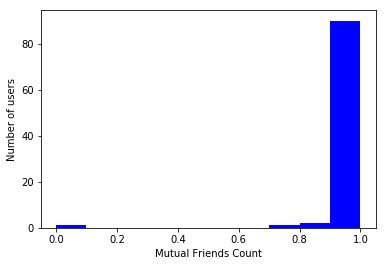

In [14]:
plt.hist(np.array(listOfMutualFrndCnt).astype('float'),color='b')
plt.xlabel('Mutual Friends Count')
plt.ylabel('Number of users')
plt.show()

In [15]:

#number of users with no mutual friend to show
print("Total users with No recommendations: "+(str(len(noMutualToShow))))
print("Inference: These users are disjoint graphs i.e. they are cyclic and every user of a graph is friend with all the users present in the same graph.")

#userids with no mutual friend to show

noMutualToShowDf= pd.DataFrame(list(noMutualToShow))
noMutualToShowDf

Total users with No recommendations: 1
Inference: These users are disjoint graphs i.e. they are cyclic and every user of a graph is friend with all the users present in the same graph.


,0
0,610445452
